In [3]:
import functools
import time

# turn on parallelism
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=50"

import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

import brax
import flax
from brax.envs import env
from brax import envs
from brax import base
from brax.io import model
from brax.io import json
from brax.io import html
from brax.io import mjcf

from inverse_kinematics.inverse_kinematics_controller import InverseKinematicsController

In [4]:
len(jax.devices())

50

In [5]:
"""
A1 env that includes the reset and step function that takes in all information of pipeline instead of using pipeline_state
"""

import jax
from jax import numpy as jp
import brax
import flax
from brax.envs import env
from brax import envs
from brax import base
from brax.io import model
from brax.io import json
from brax.io import html
from brax.io import mjcf

class SpiritRaw(env.PipelineEnv):
    def __init__(
        self, 
        path="spirit40.xml", 
        backend='generalized',
        reset_noise_scale=0.1,
        **kwargs
    ):
        sys = mjcf.load(path)
        n_frames = 1
        kwargs['n_frames'] = kwargs.get('n_frames', n_frames)
        
        super().__init__(sys=sys, backend=backend, **kwargs)
        
        self.qd_size = self.sys.qd_size()
        self.q_size = self.sys.q_size()
        
        # this might not be correct
        self.num_link = len(self.sys.link_names)
        
        self._reset_noise_scale = reset_noise_scale
        
    def reset(self, rng: jp.ndarray) -> env.State:
        # sit down
        q = jp.array([
            0., 0., 0.14, 
            1., 0., 0., 0., 
            0., 0.2, 0.2,
            0., 0.2, 0.2,
            0., 0.2, 0.2,
            0., 0.2, 0.2
        ]) 
        
        qd = jp.zeros(self.qd_size) # velocity initialized to 0
        
        pipeline_state = self.pipeline_init(q, qd)
        obs = self._get_obs(pipeline_state)
        
        reward, done, zero = jp.zeros(3)
        info = {}
        
        return env.State(pipeline_state, obs, reward, done, info)

    def _get_obs(self, pipeline_state: base.State) -> jp.ndarray:
        """Observe ant body position and velocities."""	
        qpos = pipeline_state.q
        qvel = pipeline_state.qd

        return jp.concatenate([qpos] + [qvel])
    
    def raw_pipeline_init(q, qd, x, xd):
        return brax.base.State(
            q=q,
            qd=qd,
            x=x,
            xd=xd,
            contact=None,
            com=jp.zeros(3),
            cinr=brax.base.Inertia(
                brax.base.Transform.zero((self.num_links,)),
                jp.zeros((self.num_links, 3, 3)),
                jp.zeros((self.num_links,)),
            ),
            cd=brax.base.Motion.zero((self.num_links,)),
            cdof=brax.base.Motion.zero((self.num_links,)),
            cdofd=brax.base.Motion.zero((self.num_links,)),
            mass_mx=jp.zeros((self.qd_size, self.qd_size)),
            mass_mx_inv=jp.zeros((self.qd_size, self.qd_size)),
            con_jac=jp.zeros(()),
            con_diag=jp.zeros(()),
            con_aref=jp.zeros(()),
            qf_smooth=jp.zeros_like(qd),
            qf_constraint=jp.zeros_like(qd),
            qdd=jp.zeros_like(qd),
        )
    
    def pipeline_parse(
        self, q, qd, x, xd, com, 
        cinr_transform_pos, cinr_transform_rot, cinr_i, cinr_mass, 
        cd_ang, cd_vel, cdof_ang, cdof_vel, 
        cdofd_ang, cdofd_vel, mass_mx_inv, 
        con_jac, con_aref, con_diag, 
        qf_smooth, qf_constraint, qdd
    ):
        return brax.generalized.base.State(
            q=q,
            qd=qd,
            x=x,
            xd=xd,
            contact=None,
            com=com,
            cinr=brax.base.Inertia(
                transform=brax.base.Transform(
                    cinr_transform_pos, cinr_transform_rot
                ),
                i=cinr_i,
                mass=cinr_mass
            ),
            cd=brax.base.Motion(
                ang=cd_ang,
                vel=cd_vel
            ),
            cdof=brax.base.Motion(
                ang=cdof_ang,
                vel=cdof_vel
            ),
            cdofd=brax.base.Motion(
                ang=cdofd_ang,
                vel=cdofd_vel
            ),
            mass_mx=jp.zeros_like(mass_mx_inv),
            mass_mx_inv=mass_mx_inv,
            con_jac=con_jac,
            con_aref=con_aref,
            con_diag=con_diag,
            qf_smooth=qf_smooth,
            qf_constraint=qf_constraint,
            qdd=qdd
        )
    
    def step(self, s: jp.ndarray, action: jp.ndarray, 
             x_pos, x_rot, xd_ang, xd_vel, com, 
             cinr_transform_pos, cinr_transform_rot, cinr_i, cinr_mass, 
             cd_ang, cd_vel, cdof_ang, cdof_vel, 
             cdofd_ang, cdofd_vel, mass_mx_inv, 
             con_jac, con_aref, con_diag, 
             qf_smooth, qf_constraint, qdd) -> env.State:

        q = s[:self.q_size]
        qd = s[self.q_size:]
        x = brax.base.Transform(
            x_pos, x_rot
        )
        xd = brax.base.Motion(
            xd_ang, xd_vel
        )
        
        
        pipeline_state = self.pipeline_parse(q, qd, x, xd, com, 
            cinr_transform_pos, cinr_transform_rot, cinr_i, cinr_mass, 
            cd_ang, cd_vel, cdof_ang, cdof_vel, 
            cdofd_ang, cdofd_vel, mass_mx_inv, 
            con_jac, con_aref, con_diag, 
            qf_smooth, qf_constraint, qdd)
        
        return self._step(pipeline_state, action)
        
    
    def _step(self, state: brax.base.State, action: jp.ndarray) -> env.State:
        """Run one timestep of the environment's dynamics."""
        # low level control turning reference position (input action) to torque:
        joint_pos = state.q[7:]
        joint_vel = state.qd[6:]
        e_pos = action - joint_pos
        e_v = jp.zeros(12) - joint_vel

        feedback_abduction = e_pos*120.0 + e_v*0.5
        abduction_action = jp.array([feedback_abduction[j] for j in [0, 3, 6, 9]])

        feedback_hip = e_pos*80.0 + e_v*1.0
        hip_action = jp.array([feedback_hip[j] for j in [1, 4, 7, 10]])

        feedback_knee = e_pos*120.0 + e_v*2.0
        knee_action = jp.array([feedback_knee[j] for j in [2, 5, 8, 11]])

        action = jp.array([abduction_action, hip_action, knee_action]).T.reshape(-1)
        
        pipeline_state = self.pipeline_step(state, action)
        obs = self._get_obs(pipeline_state)
        
        reward, done, zero = jp.zeros(3)
        info = {}
        
        return env.State(pipeline_state, obs, reward, done, info)

In [6]:
spirit_env = SpiritRaw()
jit_env_reset = jax.jit(spirit_env.reset, backend="cpu")
jit_env_step = jax.jit(spirit_env.step, backend="cpu")

/home/duynguyen/miniconda3/envs/spirit-rl-pybullet/lib/python3.8/site-packages/brax/io/mjcf.py:381: UserWarning: unrecognized collider, geom_type: 5
  warnings.warn(f'unrecognized collider, geom_type: {typ}')


In [7]:
controller = InverseKinematicsController()

In [8]:
def get_x(state: env.State):
    return jp.append(state.pipeline_state.q, state.pipeline_state.qd)

jax_get_x = jax.jit(get_x, backend="cpu")

In [9]:
def get_pipeline_parse(ps):
    return ps.x.pos, ps.x.rot, ps.xd.ang, ps.xd.vel, ps.com, ps.cinr.transform.pos, ps.cinr.transform.rot, ps.cinr.i, ps.cinr.mass, ps.cd.ang, ps.cd.vel, ps.cdof.ang, ps.cdof.vel, ps.cdofd.ang, ps.cdofd.vel, ps.mass_mx_inv, ps.con_jac, ps.con_aref, ps.con_diag, ps.qf_smooth, ps.qf_constraint, ps.qdd

In [45]:
# bring robot to standing position and take the first step of the controller
states = []
actions = []

rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)

current_joint = jp.array([
    0.0, 0.2, 0.2, 
    0.0, 0.2, 0.2, 
    0.0, 0.2, 0.2, 
    0.0, 0.2, 0.2
])

# stand up
reference_joint = jp.array([
    0.0, 0.7, 1.5, 
    0.0, 0.7, 1.5, 
    0.0, 0.7, 1.5,
    0.0, 0.7, 1.5
])

trajectory = jp.linspace(current_joint, reference_joint, 200)

cur_time = time.time()
for action in trajectory:
    states.append(state)
    actions.append(action)
    state = jit_env_step(get_x(state), jp.array(action), *get_pipeline_parse(state.pipeline_state))
sum_time = time.time() - cur_time

# move from stable stance to first step of performance controller
reference_joint = jp.array(controller.get_action())

trajectory = jp.linspace(state.pipeline_state.q[7:], reference_joint, 50)

cur_time = time.time()
for action in trajectory:
    states.append(state)
    actions.append(action)
    state = jit_env_step(get_x(state), jp.array(action), *get_pipeline_parse(state.pipeline_state))

# start walking
for _ in range(500):
    states.append(state)
    action = jp.array(controller.get_action())
    actions.append(action)
    state = jit_env_step(get_x(state), jp.array(action), *get_pipeline_parse(state.pipeline_state))

sum_time += time.time() - cur_time

# HTML(html.render(spirit_env.sys, [s.pipeline_state for s in states]))

In [46]:
sum_time / (200+50+500)

0.0061801951726277666

In [41]:
ss = jp.array([jax_get_x(s) for s in states[300:350]])
x_poss = jp.array([s.pipeline_state.x.pos for s in states[300:350]])
x_rots = jp.array([s.pipeline_state.x.rot for s in states[300:350]])
xd_angs = jp.array([s.pipeline_state.xd.ang for s in states[300:350]])
xd_vels = jp.array([s.pipeline_state.xd.vel for s in states[300:350]])
coms = jp.array([s.pipeline_state.com for s in states[300:350]])
cinr_transform_poss = jp.array([s.pipeline_state.cinr.transform.pos for s in states[300:350]])
cinr_transform_rots = jp.array([s.pipeline_state.cinr.transform.rot for s in states[300:350]])
cinr_is = jp.array([s.pipeline_state.cinr.i for s in states[300:350]])
cinr_masses = jp.array([s.pipeline_state.cinr.mass for s in states[300:350]])
cd_angs = jp.array([s.pipeline_state.cd.ang for s in states[300:350]])
cd_vels  = jp.array([s.pipeline_state.cd.vel for s in states[300:350]])
cdof_angs  = jp.array([s.pipeline_state.cdof.ang for s in states[300:350]])
cdof_vels  = jp.array([s.pipeline_state.cdof.vel for s in states[300:350]])
cdofd_angs  = jp.array([s.pipeline_state.cdofd.ang for s in states[300:350]])
cdofd_vels = jp.array([s.pipeline_state.cdofd.vel for s in states[300:350]])
mass_mx_invs = jp.array([s.pipeline_state.mass_mx_inv for s in states[300:350]])
con_jacs = jp.array([s.pipeline_state.con_jac for s in states[300:350]])
con_arefs = jp.array([s.pipeline_state.con_aref for s in states[300:350]])
con_diags = jp.array([s.pipeline_state.con_diag for s in states[300:350]])
qf_smooths = jp.array([s.pipeline_state.qf_smooth for s in states[300:350]])
qf_constraints = jp.array([s.pipeline_state.qf_constraint for s in states[300:350]])
qdds = jp.array([s.pipeline_state.qdd for s in states[300:350]])

In [17]:
def integrate_forward(s, u, x_pos, x_rot, xd_ang, xd_vel, com, 
        cinr_transform_pos, cinr_transform_rot, cinr_i, cinr_mass, 
        cd_ang, cd_vel, cdof_ang, cdof_vel, 
        cdofd_ang, cdofd_vel, mass_mx_inv, 
        con_jac, con_aref, con_diag, 
        qf_smooth, qf_constraint, qdd):
    
    new_state = jit_env_step(s, u, x_pos, x_rot, xd_ang, xd_vel, com, 
        cinr_transform_pos, cinr_transform_rot, cinr_i, cinr_mass, 
        cd_ang, cd_vel, cdof_ang, cdof_vel, 
        cdofd_ang, cdofd_vel, mass_mx_inv, 
        con_jac, con_aref, con_diag, 
        qf_smooth, qf_constraint, qdd
    )
    
    return jp.append(new_state.pipeline_state.q, new_state.pipeline_state.qd)

jax_integrate_forward = jax.jit(jax.jacfwd(integrate_forward, argnums=[0, 1]), backend="cpu")
jit_pmap_jacfwd = jax.pmap(jax_integrate_forward)

In [42]:
import time
cur_time = time.time()
jit_pmap_jacfwd(
    ss, jp.array(actions[300:350]), 
    x_poss, x_rots, xd_angs, xd_vels, coms, 
    cinr_transform_poss, cinr_transform_rots, cinr_is, cinr_masses, 
    cd_angs, cd_vels, cdof_angs, cdof_vels, cdofd_angs, cdofd_vels,
    mass_mx_invs, con_jacs, con_arefs, con_diags, qf_smooths, qf_constraints, qdds
)
print((time.time() - cur_time)/50)

0.0007563638687133789


## Benchmarking computing time

In [48]:
# bring robot to standing position and take the first step of the controller
states = []
actions = []
time_elapsed = []

rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)

current_joint = jp.array([
    0.0, 0.2, 0.2, 
    0.0, 0.2, 0.2, 
    0.0, 0.2, 0.2, 
    0.0, 0.2, 0.2
])

# stand up
reference_joint = jp.array([
    0.0, 0.7, 1.5, 
    0.0, 0.7, 1.5, 
    0.0, 0.7, 1.5,
    0.0, 0.7, 1.5
])

trajectory = jp.linspace(current_joint, reference_joint, 200)

for action in trajectory:
    cur_time = time.time()
    states.append(state)
    actions.append(action)
    state = jit_env_step(get_x(state), jp.array(action), *get_pipeline_parse(state.pipeline_state))
    time_elapsed.append(time.time() - cur_time)

# move from stable stance to first step of performance controller
reference_joint = jp.array(controller.get_action())

trajectory = jp.linspace(state.pipeline_state.q[7:], reference_joint, 50)

for action in trajectory:
    cur_time = time.time()
    states.append(state)
    actions.append(action)
    state = jit_env_step(get_x(state), jp.array(action), *get_pipeline_parse(state.pipeline_state))
    time_elapsed.append(time.time() - cur_time)

# start walking
for _ in range(500):
    cur_time = time.time()
    states.append(state)
    action = jp.array(controller.get_action())
    actions.append(action)
    state = jit_env_step(get_x(state), jp.array(action), *get_pipeline_parse(state.pipeline_state))
    time_elapsed.append(time.time() - cur_time)

Text(0, 0.5, 'Count (Total 750 steps)')

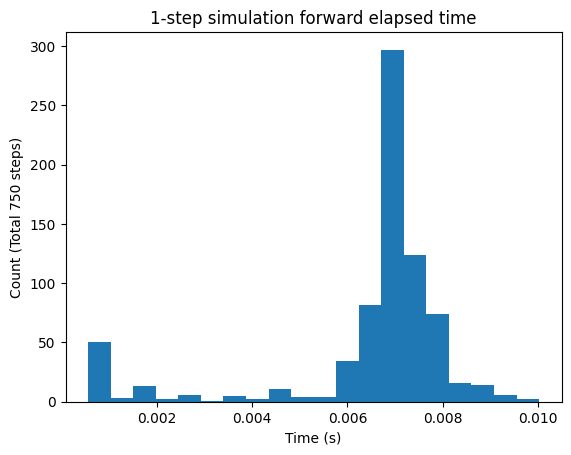

In [62]:
plt.title("1-step simulation forward elapsed time")
plt.hist(time_elapsed, bins=20)
plt.xlabel("Time (s)")
plt.ylabel("Count (Total 750 steps)")
plt.show()

In [88]:
time_elapsed = []

for j in range(10):
    for i in range(int(750/50)):
        start = i*50
        stop = (i+1)*50
        ss = jp.array([jax_get_x(s) for s in states[start:stop]])
        x_poss = jp.array([s.pipeline_state.x.pos for s in states[start:stop]])
        x_rots = jp.array([s.pipeline_state.x.rot for s in states[start:stop]])
        xd_angs = jp.array([s.pipeline_state.xd.ang for s in states[start:stop]])
        xd_vels = jp.array([s.pipeline_state.xd.vel for s in states[start:stop]])
        coms = jp.array([s.pipeline_state.com for s in states[start:stop]])
        cinr_transform_poss = jp.array([s.pipeline_state.cinr.transform.pos for s in states[start:stop]])
        cinr_transform_rots = jp.array([s.pipeline_state.cinr.transform.rot for s in states[start:stop]])
        cinr_is = jp.array([s.pipeline_state.cinr.i for s in states[start:stop]])
        cinr_masses = jp.array([s.pipeline_state.cinr.mass for s in states[start:stop]])
        cd_angs = jp.array([s.pipeline_state.cd.ang for s in states[start:stop]])
        cd_vels  = jp.array([s.pipeline_state.cd.vel for s in states[start:stop]])
        cdof_angs  = jp.array([s.pipeline_state.cdof.ang for s in states[start:stop]])
        cdof_vels  = jp.array([s.pipeline_state.cdof.vel for s in states[start:stop]])
        cdofd_angs  = jp.array([s.pipeline_state.cdofd.ang for s in states[start:stop]])
        cdofd_vels = jp.array([s.pipeline_state.cdofd.vel for s in states[start:stop]])
        mass_mx_invs = jp.array([s.pipeline_state.mass_mx_inv for s in states[start:stop]])
        con_jacs = jp.array([s.pipeline_state.con_jac for s in states[start:stop]])
        con_arefs = jp.array([s.pipeline_state.con_aref for s in states[start:stop]])
        con_diags = jp.array([s.pipeline_state.con_diag for s in states[start:stop]])
        qf_smooths = jp.array([s.pipeline_state.qf_smooth for s in states[start:stop]])
        qf_constraints = jp.array([s.pipeline_state.qf_constraint for s in states[start:stop]])
        qdds = jp.array([s.pipeline_state.qdd for s in states[start:stop]])

        cur_time = time.time()
        jit_pmap_jacfwd(
            ss, jp.array(actions[start:stop]), 
            x_poss, x_rots, xd_angs, xd_vels, coms, 
            cinr_transform_poss, cinr_transform_rots, cinr_is, cinr_masses, 
            cd_angs, cd_vels, cdof_angs, cdof_vels, cdofd_angs, cdofd_vels,
            mass_mx_invs, con_jacs, con_arefs, con_diags, qf_smooths, qf_constraints, qdds
        )
        time_elapsed.append((time.time() - cur_time)/50.0)

KeyboardInterrupt: 

In [110]:
time_elapsed_filter = [x for x in time_elapsed if x < 0.1]

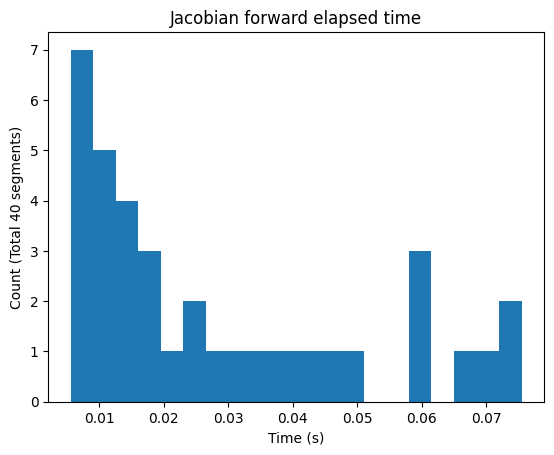

In [113]:
plt.title("Jacobian forward elapsed time")
plt.hist(time_elapsed_filter, bins=20)
plt.xlabel("Time (s)")
plt.ylabel("Count (Total 40 segments)")
plt.show()

In [117]:
max(time_elapsed)

0.5652146100997925

In [118]:
min(time_elapsed)

0.005535225868225097